# Analysis of transactions

In [1]:
import functions

import pandas as pd
from datetime import datetime as dt
from dateutil import relativedelta
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'browser'

## user input

In [2]:
# column names
clm = dict(
    date       = 'date'      ,  # in transactions file
    amount     = 'amount'    ,  # in transactions file
    category   = 'category'  ,  # in transactions file
    balance    = 'balance'   ,  # in transactions file
    cat_fine   = 'type'      ,  # for fine categories
    expenses   = 'EXPENSES'  ,  # for result
    sum        = 'SUM'       ,  # for result
    mean_month = '/MONTH'    ,  # for result
    )

# forecast
next_months = 1

## read & modify transactions
- load file

In [3]:
transactions = pd.read_csv('transactions.csv', encoding = "ISO-8859-1")

# transactions[clm['date']] = pd.to_datetime(transactions[clm['date']], format='%d.%m.%Y')
transactions[clm['date']] = pd.to_datetime(transactions[clm['date']], format='%Y-%m-%d')

- filter time

In [4]:
year = 2022
transactions = transactions.query('date.dt.year >= @year and date.dt.year < @year + 1')

# year = 2022
# month = 8
# transactions = transactions[ (transactions[clm['date']] >= dt(year,month,1)) & (transactions[clm['date']] < dt(year,month+1,1)) ]

# transactions = transactions[ transactions[clm['date']] >= dt.today() - relativedelta.relativedelta(years=1) ]

# transactions = transactions[ transactions[clm['date']] >= dt(2022,9,1) ]

- filter category

In [5]:
# transactions = transactions[~ transactions[clm['category']].isin(['vacation/lodging'])]

## table sum per month & category
- create table from transactions

In [6]:
sum_cat_month = functions.get_sum_cat_month(transactions, clm, next_months)

pd.options.display.float_format = '{:,.0f}'.format
sum_cat_month.fillna(0)

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,SUM,/MONTH,2023-01
flat/ancillary costs,-305,-76,-83,-76,-76,-76,-100,-100,-93,-93,-93,-93,"-1,262",-106,-106
flat/furniture,-43,0,-99,-119,0,0,-18,-26,0,0,0,0,-305,-28,-28
flat/rent,"-1,000","-1,000","-1,000","-1,000","-1,000","-1,000","-1,000","-1,000","-1,000","-1,000","-1,000","-1,000","-12,000","-1,000","-1,000"
income,"2,700","2,700","2,700","2,700","2,700","2,700","2,700","2,700","2,700","2,700","2,700","2,700","32,400","2,700","2,700"
leisure/clubs,-113,0,0,0,0,0,0,0,0,0,0,0,-113,-10,-10
leisure/food,0,0,-98,-115,-267,-417,-36,-408,-55,-263,-227,-105,"-1,991",-171,-171
leisure/going out,0,0,-200,0,-149,0,0,0,0,-22,0,-43,-414,-34,-34
leisure/hobby,-20,0,-72,-34,0,-62,-95,-4,0,0,-32,-12,-330,-29,-29
leisure/sport,0,0,-55,0,0,0,0,0,-77,-7,-20,-20,-179,-14,-14
living expenses/cash,-200,0,0,-185,-186,0,-160,-89,-100,-294,0,-57,"-1,271",-110,-110


- save table to excel

In [7]:
# result_name = ('overview_' + 
#                 str(min(transactions[clm['date']]))[:10] + '__' + 
#                 str(max(transactions[clm['date']]))[:10] )

# sum_cat_month.to_excel(result_name + '.xlsx')

## plot

- sunburst all categories

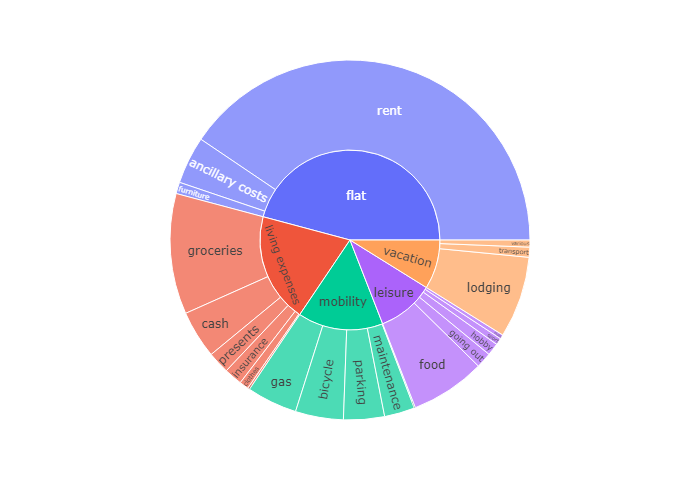

Total spendings: 29596 €


In [8]:
transactions[ [ clm['category'] , clm['cat_fine'] ] ] = transactions[clm['category']].str.split('/', expand=True)
transactions[clm['cat_fine']].fillna("", inplace=True)

df_sunburst = transactions.groupby([clm['cat_fine'] , clm['category']], as_index=False)
df_sunburst = df_sunburst.agg({clm['amount']: 'sum', clm['category']: 'first'})
df_sunburst = df_sunburst[ df_sunburst[clm['amount']] < 0]
df_sunburst[clm['amount']] = df_sunburst[clm['amount']].abs()

fig = px.sunburst(df_sunburst, path=[clm['category'], clm['cat_fine']], values=clm['amount'])
# fig.show() 
fig.show('png')

print(f"Total spendings: { int(df_sunburst[clm['amount']].sum()) } €")

- balance over time

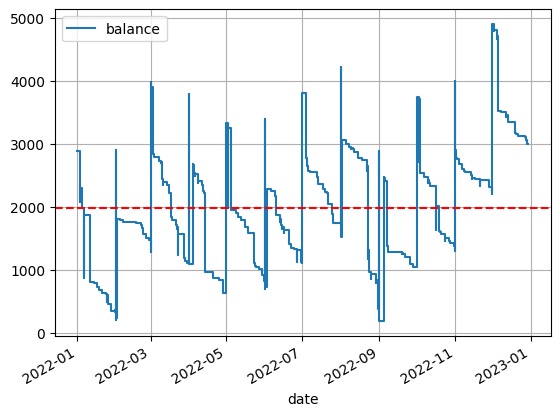

Balance over time: 2803.28 €
Current balance: 3000.0 €


In [9]:
transactions.plot(clm['date'], clm['balance'], drawstyle='steps-post')
plt.axhline(y=transactions.set_index(clm['date']).resample('1D').mean(numeric_only=True).interpolate(method='pad').mean()[clm['balance']], color='r', linestyle='--')
plt.grid()
plt.show()

balance = ( transactions.iloc[-1][clm['amount' ]]
          + transactions.iloc[ 0][clm['balance']]
          - transactions.iloc[-1][clm['balance']] )
print(f"Balance over time: { round( balance , 2) } €")

print(f"Current balance: { transactions.iloc[0][clm['balance']] } €")

- dataframe for plots

In [10]:
df_plot_fine = sum_cat_month.transpose().drop([ clm['sum'], clm['mean_month'] ])

sum_cat_month_rough = sum_cat_month.reset_index()
sum_cat_month_rough['index'] = sum_cat_month_rough['index'].str.split('/', expand=True)[0]
sum_cat_month_rough = sum_cat_month_rough.groupby('index').sum()

df_plot_rough = sum_cat_month_rough.transpose().drop([ clm['sum'], clm['mean_month'] ]).drop([clm['sum'], clm['expenses']],axis=1)

- all categories per month

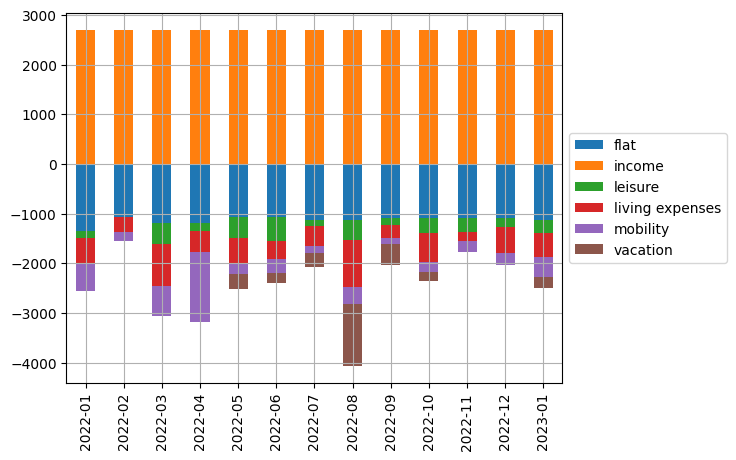

In [11]:
df_plot_rough.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid()
plt.show()

- saldo per month

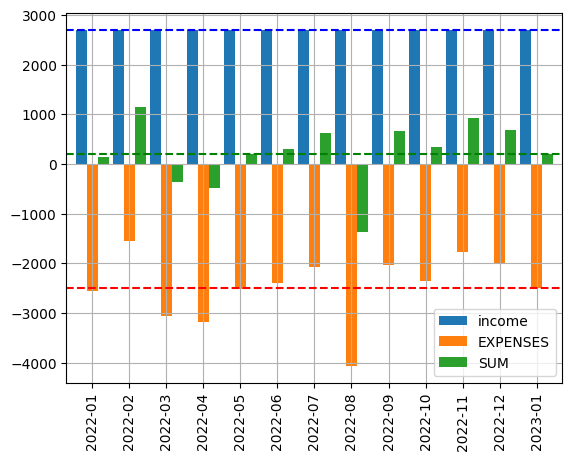

In [15]:
df_plot_fine.plot.bar(y=['income',clm['expenses'],clm['sum']] , width=0.9)
plt.axhline(y=sum_cat_month.loc['income',clm['mean_month']], color='b', linestyle='--')
plt.axhline(y=sum_cat_month.loc[clm['expenses'],clm['mean_month']], color='r', linestyle='--')
plt.axhline(y=sum_cat_month.loc[clm['sum'],clm['mean_month']], color='g', linestyle='--')
plt.grid()
plt.show()

- individual categories per month

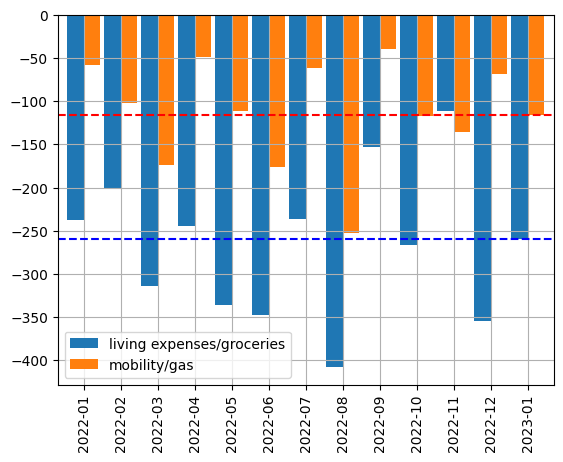

In [14]:
df_plot_fine.plot.bar(y=['living expenses/groceries','mobility/gas'], width=0.9)
plt.axhline(y=sum_cat_month.loc['living expenses/groceries',clm['mean_month']], color='b', linestyle='--')
plt.axhline(y=sum_cat_month.loc['mobility/gas',clm['mean_month']], color='r', linestyle='--')
plt.grid()
plt.show()